Project proposal
Reqs:

**Specific expectations for the proposal:**

Each group is expected to prepare a 1 page (max 500 words) written proposal that identifies the dataset they plan to work on, as well as the question they would like to answer using that dataset for their group project. The proposal should be done in a Jupyter notebook, and then submitted both as an .html file (File -> Download As -> HTML) and an .ipynb file that is reproducible (i.e. works and runs without any additional files.)

Each proposal should include the following sections:

**Title**

**Introduction:**

Sleep is a fundamental aspect of human life and is critical to physical and mental health. However, many people suffer from sleep disorders, which involve problems with the quality, timing, and amount of sleep. The two most common sleep disorders are sleep apnea, where breathing frequently stops during sleep, and insomnia, where people have difficulty falling and staying asleep. Sleep disorders can be influenced by lifestyle and are often comorbid with chronic health disorders.

In our project, we will utilise the Sleep Health and Lifestyle Dataset. This dataset is a collection of information pertaining to sleep, lifestyle factors, cardiovascular health, and sleep disorders. Using the dataset, we aim to determine: “How can lifestyle and physiological measures be used to determine the absence or presence of diagnosed sleep disorders?” 

**Preliminary exploratory data analysis:**
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

**Methods:**
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results


**Expected outcomes and significance:**

From our project, we expect to create a classification model that is able to predict an unclassified observation’s presence of a sleep disorder based on given physiological measures and lifestyle factors, as well as find the best K parameter that would provide the most accurate classifying model. These findings may help determine common factors associated with sleep disorder patients and which factors are strongly or weakly linked.

Future questions our project could lead to are:
- What forms of interventions could be implemented to help the populations most affected by sleep disorders?
- Is there one factor that best predicts the presence of sleep disorders?
- Are there any other factors relating to lifestyle habits that also correlate with sleep disorder diagnosis?
 

In [10]:
library(tidyverse)
library(tidymodels)
sleep_data <- read_csv("Sleep_health_and_lifestyle_dataset.csv", skip = 1)

Rows: 748 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
colnames(sleep_data) <- make.names(colnames(sleep_data))

In [12]:
#removing NA values
sleep_data <- na.omit(sleep_data)

In [16]:
#separating bp column
sleep_data <- separate(sleep_data,
    col = Blood.Pressure,
    into = c("Systolic.BP", "Diastolic.BP"),
    sep = "/",
    convert = TRUE) 

In [17]:
#removing unwanted predictors
sleep_data_2 <- sleep_data |>
    select(-Gender, -Occupation, -BMI.Category)
head(sleep_data_2)

Person.ID,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Sleep.Disorder
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,27,6.1,6,42,6,126,83,77,4200,None
2,28,6.2,6,60,8,125,80,75,10000,None
3,28,6.2,6,60,8,125,80,75,10000,None
4,28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
5,28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
6,28,5.9,4,30,8,140,90,85,3000,Insomnia


In [18]:
#combining 'sleep apnea' and 'insomnia' into 'sleep disorders'
sleep_apnea_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Sleep Apnea") |>
select(-Sleep.Disorder)
sleep_apnea_tidy <- data.frame(sleep_apnea_untidy, Diagnosis = "Sleep Disorder")

insomnia_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Insomnia") |>
select(-Sleep.Disorder)
insomnia_tidy <- data.frame(insomnia_untidy, Diagnosis = "Sleep Disorder")

none_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "None") |>
select(-Sleep.Disorder)
none_tidy <- data.frame(none_untidy, Diagnosis = "None")

tidy_sleep_data <- rbind(sleep_apnea_tidy, insomnia_tidy, none_tidy)

head(tidy_sleep_data)

,Person.ID,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Diagnosis
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,4,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
2,5,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
3,17,29,6.5,5,40,7,132,87,80,4000,Sleep Disorder
4,18,29,6.0,6,30,8,120,80,70,8000,Sleep Disorder
5,31,30,6.4,5,35,7,130,86,78,4100,Sleep Disorder
6,50,31,7.7,7,75,6,120,80,70,8000,Sleep Disorder


In [19]:
#splitting the data into training and test sets
sleep_split <- initial_split(tidy_sleep_data, prop = 0.75, strata = Diagnosis)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

The table below represents the number of observations and percentages for each class in the training set.

In [20]:
summary_table_1 <- sleep_train |>
  group_by(Diagnosis) |>
  summarize(count = n(), percentage = n()/nrow(sleep_train)*100)

summary_table_1

Diagnosis,count,percentage
<chr>,<int>,<dbl>
None,164,58.57143
Sleep Disorder,116,41.42857


The table below represents the means for each predictor in the training set.

In [21]:
summary_table_2 <- summarize(sleep_train, across(Age:Daily.Steps, mean))
summary_table_2

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42.375,7.157143,7.346429,59.87857,5.346429,128.4536,84.65,70.13929,6850.357


Bar plot comparing mean stress level between those with a sleep disorder or without a sleep disorder.

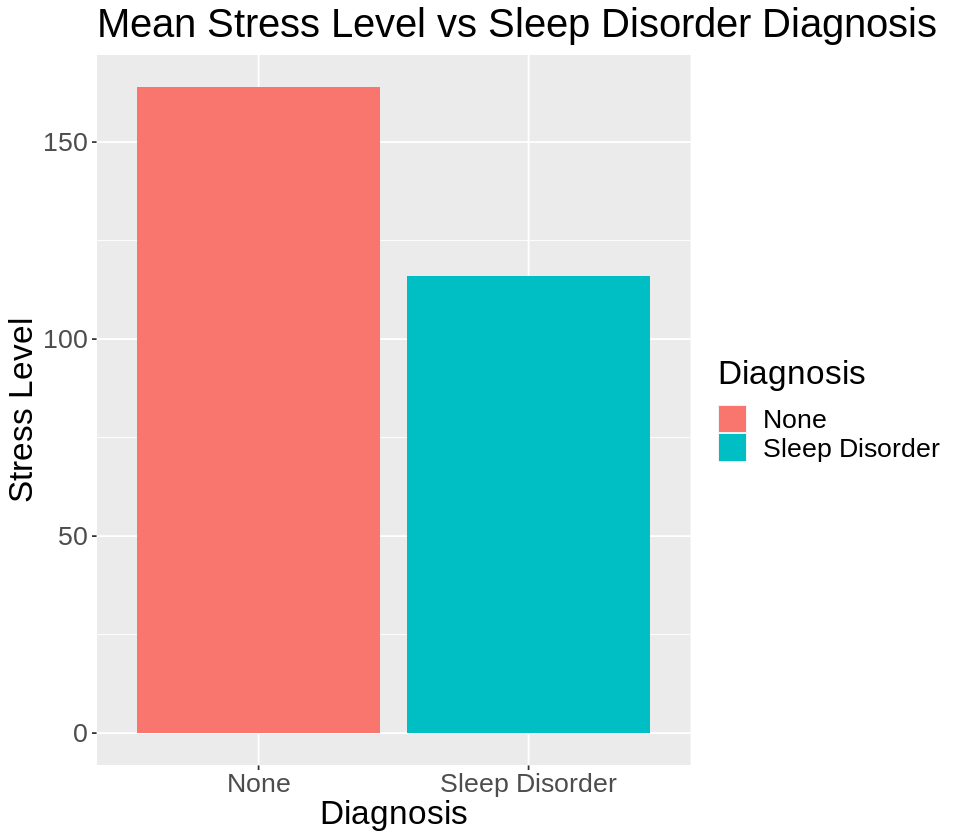

In [22]:
library(ggplot2)
library(repr)
library(tidyverse)
options(repr.plot.width = 8, repr.plot.height = 7)

mean_stress_plot <- sleep_train |>
        ggplot(aes(x = Diagnosis, fill = Diagnosis))+
        geom_bar()+
        labs(x = "Diagnosis", y = "Stress Level")+
        theme(text = element_text(size = 20))+
        ggtitle("Mean Stress Level vs Sleep Disorder Diagnosis")
mean_stress_plot
        